# RLLBC Bonus Point Assignment II Part B
<div style="text-align: right;font-size: 0.8em">Document Version 1.0.0, released 2022-06-24</div>
For task instructions, refer to the assignment PDF.

* The parts of the code you are to implement are indicated via `# TODO` comments.
* You can use the `# Test code` cells to verify your implementation. However note that these are not the unit tests used for grading.
* Some cells create export file in the `solution/` folder. _Include whole `solution/` folder in your submission_.
* DO NOT CLEAR THE OUTPUT of the notebook you are submitting!

In [1]:
# General imports
from pathlib import Path
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gym
from tqdm.auto import tqdm
rng = np.random.RandomState(1234)

# Create solution folder
Path("solution/").mkdir(exist_ok=True)

/home/shubham/miniconda3/envs/rllbc_bpa2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Question B1 - Deep Q-Networks
### a) Implement Replay Buffer

In [2]:
class ReplayBuffer(object):
    def __init__(self, mem_size, state_shape):
        """Initialization of the replay buffer.
        
        The memories have the following data types:
            states: float32
            next_states: float32
            actions: int64
            rewards: float32
            is_terminal: bool

        Args:
            mem_size: Capacity of this buffer
            state_shape: Shape of state and next_state
        """
        self.mem_size = mem_size  # Capacity of the buffer
        self.mem_cntr = 0         # Number of added elements
        self.state_memory = np.zeros((self.mem_size, *state_shape), dtype=np.float32)
        self.next_state_memory = np.zeros((self.mem_size, *state_shape), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)
        self.state_shape = state_shape
    def is_filled(self):
        """Check if the memory is filled."""
        return buffer.mem_cntr >= buffer.mem_size

    def add(self, state, action, reward, next_state, is_terminal):
        """Add one transition to the buffer.

        Replaces the oldest transition in memory.
        """
        # TODO
        i = self.mem_cntr % self.mem_size
        
        self.state_memory[i] = state
        self.next_state_memory[i] = next_state
        self.action_memory[i] = action
        self.reward_memory[i] = reward
        self.terminal_memory[i] = is_terminal
        self.mem_cntr += 1
    def sample_batch(self, batch_size):
        """Sample one batch from the memory."""
        # TODO
        idx = []
        for i in range(batch_size):
            idx.append(rng.randint(0,self.mem_size))
            
        
        states = np.zeros((batch_size,*self.state_shape),dtype=np.float32)
        actions = np.zeros(batch_size,dtype=np.int64)
        next_states = np.zeros((batch_size,*self.state_shape),dtype=np.float32)
        rewards = np.zeros(batch_size, dtype=np.float32)
        is_terminal =  np.zeros(batch_size, dtype=np.bool)
        for i in range(len(idx)):
            states[i] = self.state_memory[idx[i]]
            next_states[i] = self.next_state_memory[idx[i]]
            actions[i] = self.action_memory[idx[i]] 
            rewards[i] = self.reward_memory[idx[i]]
            is_terminal[i] = self.terminal_memory[idx[i]]
            
        return states, actions, rewards, next_states, is_terminal

In [3]:
# Test code
_buffer = ReplayBuffer(10, (5, ))
assert _buffer.mem_size == 10
assert _buffer.mem_cntr == 0
for i in range(10):  # Fill test values
    _buffer.add(np.arange(5) + i, 5 + i, 6 + i, 7 + np.arange(5) + i, (12 + i) % 2 == 0)
assert _buffer.mem_size == 10
assert _buffer.mem_cntr == 10, "Wrong mem_cntr"

_is = set()
for s, a, r, s_, t in zip(*_buffer.sample_batch(5)):
    i = s[0]
    assert 0 <= i < 10, "Wrong states"
    _is.add(i)
    np.testing.assert_array_equal(s, np.arange(5) + i, err_msg="Wrong states")
    np.testing.assert_equal(a, 5 + i, err_msg="Wrong actions")
    np.testing.assert_equal(r, 6 + i, err_msg="Wrong rewards")
    np.testing.assert_array_equal(s_, 7 + np.arange(5) + i, err_msg="Wrong next states")
    np.testing.assert_equal(t, (12 + i) % 2 == 0, err_msg="Wrong terminals")
assert len(_is) == 5, "Duplicate transitions"
"ok"

/tmp/ipykernel_8011/1616720695.py:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)


'ok'

### b) Fill replay buffer

In [4]:
env = gym.make('CartPole-v1')

# Initialize replay buffer
buffer = ReplayBuffer(mem_size=25000, state_shape=env.observation_space.shape)

# ********************
# TODO Sample transitions from environment and add to buffer
next_state = env.reset()
for i in range(buffer.mem_size):
    state = next_state
    action = env.action_space.sample()
    next_state, reward, is_terminal,_ = env.step(action)

    buffer.add(state, action, reward, next_state, is_terminal)


/home/shubham/miniconda3/envs/rllbc_bpa2/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(
/tmp/ipykernel_8011/1616720695.py:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)
/home/shubham/miniconda3/envs/rllbc_bpa2/lib/python3.9/site-packages/gym/envs/classic_control/cartpole.py:171: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always

In [7]:
# Test code
assert buffer.is_filled(), f"Buffer not filled, only {buffer.mem_cntr}/{buffer.mem_size} transitions in memory"
"ok"

'ok'

## Question B2 - Deep Q-Networks
### a) Define Q-Network

In [5]:
import torch
from torch import nn
import torch.nn.functional as F

class DeepQNetwork(nn.Module):
    def __init__(self):
        super(DeepQNetwork, self).__init__()
        # TODO Create layers
        self.layer1 = nn.Linear(4,128)
        self.layer2 = nn.Linear(128,2)



    def forward(self, state):
        # TODO Implement forward pass
        x = F.relu(self.layer1(state))
        Q = self.layer2(x)
        # Q = F.tanh(y)
       # ********************

        return Q

In [6]:
# Test code
_test_output = DeepQNetwork()(torch.FloatTensor([[1, 2, 3, 4]]))
assert _test_output.shape == (1, 2), f"Expected output shape (1, 2), got {_test_output.shape}"
"ok"

'ok'

### b) $\epsilon$-Greedy

In [11]:
def epsilon_greedy(state, q_network, epsilon=0.05):
    """Perform epsilon-greedy action sampling.

    Args:
        state: numpy ndarray, current state
        q_network: torch module

    Returns:
        action: one action
    """
    # TODO Epsilon-greedy action sampling
    Q = q_network.forward(torch.tensor([state]))
    #Q = q_network.forward(state)
    if np.random.rand() < epsilon:
        action = env.action_space.sample()
    else:
        action = torch.argmax(Q) 

    action = int(action)
    
    return action

/tmp/ipykernel_4969/2591415914.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1648016052946/work/torch/csrc/utils/tensor_new.cpp:198.)
  Q = q_network.forward(torch.tensor([state]))


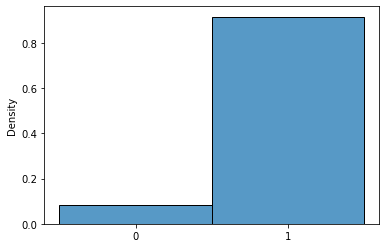

In [12]:
# Test Code
class DummyModule(nn.Module):
    def forward(self, state):
        return torch.FloatTensor([1, 2])  # Constant output


# Sample 1000 actions
_actions = [epsilon_greedy(np.array([1, 2, 3, 4]), DummyModule(), epsilon=0.2) for _ in range(1000)]

sns.histplot(_actions, discrete=True, stat="density")
plt.xticks([0, 1])
plt.show()

_zeros = 1000 - sum(_actions)
# Note: This is a stochastic test. It produces a false error in 1% of the cases
assert 75 < _zeros < 125, f"Frequency of action 0 ({_zeros}) is outside the 99% confidence interval [76, 124]"

### c) Loss Function

In [28]:
from numpy import float64


mse = nn.MSELoss()

def compute_loss(q_network, target_network, states, actions, rewards, next_states, is_terminal, gamma=0.99):
    # TODO Implement loss function
    qvals , expected_qvals, target_qvals = [], [], []
    # qvals = np.zeros_like((states,*actions))
    # expected_qvals = np.zeros_like((states,*actions))
    for s, ns, a , r, ter in zip(states, next_states,actions, rewards, is_terminal):
        if ter == True:
            # qvals[int(s)] = 0
            qvals.append(0)
            # expected_qvals[int(ns)] = 0
            target_qvals.append(0)
        # else:
            # qvals[int(s)] = q_network(s)[a]
        qvals.append((q_network(s)[a])).squeeze(1)
        target_qvals.append((target_network(s)[a])).squeeze(1)
            # expected_qvals[int(ns)] = r+gamma*np.argmax(target_network(ns))
        expected_qvals.append(r+gamma*torch.argmax(target_qvals))
            
        
        
    # print(qvals)
    # print(expected_qvals)

    loss = mse(qvals, expected_qvals)
    return loss

In [29]:
mse = nn.MSELoss1()

def compute_loss(q_network, target_network, states, actions, rewards, next_states, is_terminal, gamma=0.99):
    # TODO Implement loss function
    # qvals = ...
    qvals = []
    # best_actions = []
    target_qvals = []

    # for s, ns, terminal in zip(states, next_states, is_terminal):

    #     qvals.append(q_network(s).gather(1, actions)) # corresponding action?
    #     best_actions.append(action = torch.argmax(qvals[-1]))
    #     target_qvals.append(target_network(ns).detach().max(1)[0])
    #     if terminal:
    #         target_qvals[-1] = 0
    # # expected_qvals = ...        
    # expected_qval = []
    # for tq, r in zip(target_qvals, rewards):
    #     expected_qval.append(r + gamma*tq)

    # loss = mse(qvals, expected_qvals.unsqueeze(1))
    # # print(target_qvals.shape())


    qvals = q_network.forward(states).squeeze(1)
    target_qvals = target_network.forward(next_states).squeeze(1)
    qvals = torch.sum(qvals.mul(actions), dim=1)
    target_qvals[is_terminal] = 0
    expected_qval = rewards + gamma * target_qvals.max(1)[0]


    # qvals = q_network.forward(states).gather(1, actions.view(actions.size(0), 1))
    # target_qvals = target_network.forward(next_states)
    # target_qvals[is_terminal] = 0
    # # dones = is_terminal.int().view(is_terminal.size(0))
    # max_next_Q = torch.max(target_qvals, 1)[0]
    # max_next_Q = max_next_Q.view(max_next_Q.size(0), 1)
    # expected_qval = rewards + gamma * max_next_Q

    loss = mse(qvals, expected_qval.detach())

AttributeError: module 'torch.nn' has no attribute 'MSELoss1'

### d) Training

In [30]:
# Hyperparameters
epsilon = 0.05  # For epsilon greedy action sampling
batch_size = 64
NETWORK_UPDATE_FREQUENCY = 4
NETWORK_SYNC_FREQUENCY = 2000
gamma = 0.99
episodes = 10000
replay_buffer_size = 0 #TODO


q_network = DeepQNetwork()
target_network = deepcopy(q_network)
optimizer = torch.optim.Adam(q_network.parameters(), lr=1e-3)
mse = nn.MSELoss()

step_count = 0
total_rewards = []
with tqdm(range(episodes)) as pbar:
    for _ in pbar:
        state, done = env.reset(), False
        rewards = []

        while not done:
            # Take a step
            action = epsilon_greedy(state, q_network, epsilon=epsilon)
            next_state, reward, done, _ = env.step(action)

            # Bookkeeping
            rewards.append(reward)
            buffer.add(state=state, action=action, reward=reward, next_state=next_state, is_terminal=done and env._elapsed_steps < 500)
            state = next_state

            step_count += 1

            # Update network every NETWORK_UPDATE_FREQUENCY steps
            if step_count % NETWORK_UPDATE_FREQUENCY == 0:
                # Sample batch of transitions
                state_batch, action_batch, reward_batch, next_state_batch, terminal_batch = buffer.sample_batch(batch_size=batch_size)
                state_batch = torch.FloatTensor(state_batch)
                next_state_batch = torch.FloatTensor(next_state_batch)
                action_batch = torch.LongTensor(action_batch).reshape(-1, 1)
                reward_batch = torch.FloatTensor(reward_batch).reshape(-1, 1)
                terminal_batch = torch.BoolTensor(terminal_batch)

                # Compute loss
                loss = compute_loss(q_network, target_network, state_batch, action_batch, reward_batch, next_state_batch, terminal_batch, gamma)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
           
            # Sync networks every NETWORK_SYNC_FREQUENCY steps
            if step_count % NETWORK_SYNC_FREQUENCY == 0:
                # ********************
                # TODO Synchronize networks
                
                target_network.load_state_dict(q_network.state_dict())


                # ********************
        total_rewards.append(sum(rewards))

         # Print statistics
        pbar.set_description(f"Mean training reward {np.mean(total_rewards[-100:]):.02f}")
        if np.mean(total_rewards[-100:]) == 500:
            break # Stop training

# Save model
with open("solution/b2d.pt", "wb") as f:
    torch.save(q_network, f)

# Plot training
plt.plot(total_rewards, label="per episode")
plt.plot(pd.DataFrame(total_rewards).rolling(100).mean(), label="average reward")
plt.xlabel("epoch")
plt.ylabel("reward")
plt.legend()
plt.tight_layout()
plt.savefig("solution/b2d.png")

  0%|          | 0/10000 [00:00<?, ?it/s]/home/shubham/miniconda3/envs/rllbc_bpa2/lib/python3.9/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/tmp/ipykernel_4969/1616720695.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_terminal =  np.zeros(batch_size, dtype=np.bool)
  0%|          | 0/10000 [00:00<?, ?it/s]


AttributeError: 'NoneType' object has no attribute 'squeeze'

In [12]:
# Test code
policy = q_network
policy.eval()  # Switch to evaluation mode


def _rollout(seed):
    env.reset(seed=seed)
    state, done = env.reset(), False
    while not done:
        probs = policy(torch.tensor(state).float().reshape((1, -1)))[0]
        action = np.argmax(probs.detach().numpy())  # Greedy action
        state, reward, done, _ = env.step(action)
    return env._elapsed_steps


_avg_reward = np.mean([_rollout(seed=i) for i in tqdm(range(100), desc="Validating")])
assert _avg_reward >= 487.5, f"Average reward below 487.5, got {_avg_reward}"
f"ok (Average reward {_avg_reward:0.2f})"

Validating:   0%|          | 0/100 [00:00<?, ?it/s]

'ok (Average reward 500.00)'